In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd 
import numpy as np
from scipy import linalg, stats

import matplotlib.pyplot as plt

import mahalanobis as maha

In [3]:
# We used the same number of components for Mahalanobis distance in Covid-Confirm and Covid-Combo
N_COMPONENTS = 18

In [4]:
df_single = pd.read_parquet('data/covid_confirm.parquet.gzip')
meta_cols_single = [
    'type',
    'batch_id',
    'conc',
]

df_combo = pd.read_parquet("data/covid_combo.parquet.gzip")
meta_cols_combo = [
    'type',
    'batch_id_1',
    'conc_1',
    'batch_id_2',
    'conc_2',
]

# Keep only overlapping features
morphology_cols_single = list(set(df_single.columns).difference(set(meta_cols_single)))
morphology_cols_combo = list(set(df_combo.columns).difference(set(meta_cols_combo)))
common_morphology_cols = list(set(morphology_cols_single).intersection(set(morphology_cols_combo)))

print(f"Single: # of morphological features: {len(morphology_cols_single)}")
print(f"Combo: # of morphological features: {len(morphology_cols_combo)}")
print(f"Single + Combo: # of morphological features: {len(common_morphology_cols)}")

df_single = df_single[meta_cols_single + common_morphology_cols]
df_combo = df_combo[meta_cols_combo + common_morphology_cols]

Single: # of morphological features: 1467
Combo: # of morphological features: 2121
Single + Combo: # of morphological features: 1467


In [5]:
df_single_good = df_single[df_single['type'] == 'uninfected'].copy()
df_combo_good = df_combo[df_combo['type'] == 'uninfected'].copy()

# morphological profile of uninfected cells ('good')
x_single_good = df_single_good.drop(columns=meta_cols_single).to_numpy()
x_combo_good = df_combo_good.drop(columns=meta_cols_combo).to_numpy()
x_good = np.concatenate([x_single_good, x_combo_good])

In [6]:
def get_singular_vals(X):
    cov_matrix = np.cov(X, rowvar=False)
    sigma, u = linalg.eigh(cov_matrix, check_finite=True)
    rank = min(*X.shape) - 1
    sigma = sigma[::-1]
    # remove values under ~float precision
    too_low = len(sigma[sigma>1e-8])
    rank = min(rank, too_low)
    sigma = sigma[:rank]
    return sigma

In [7]:
sigma_single = get_singular_vals(x_single_good)
sigma_combo = get_singular_vals(x_combo_good)
sigma = get_singular_vals(x_good)

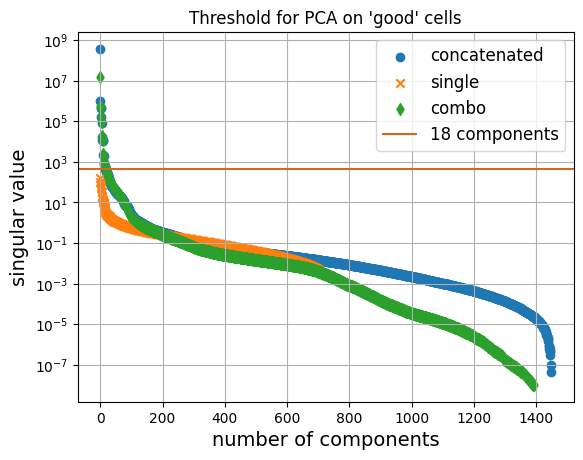

In [8]:
plt.scatter(range(len(sigma)), sigma, label='concatenated')
plt.scatter(range(len(sigma_single)), sigma_single, label='single', marker='x')
plt.scatter(range(len(sigma_combo)), sigma_combo, label='combo', marker='d')

# manual threshold
n_comp = N_COMPONENTS
thresh = sigma[n_comp]
plt.axhline(thresh, c='chocolate', label=f'{n_comp} components')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on 'good' cells")
plt.show()

In [9]:
# Omit 'uninfected' from the set for predictions
def get_predictions(df, meta_cols, x_good, n_components):
    df_cells = df[df['type'] != 'uninfected']
    x_cells = df_cells.drop(
        columns=set(meta_cols).intersection(df.columns)
    ).copy()

    dist_pred = maha.get_distance(x_good, x_cells, n_components=n_components)
    df_dist = pd.DataFrame(dist_pred, columns=['distance'])

    proba_pred = maha.get_proba(x_good, x_cells, n_components=n_components)
    df_proba = pd.DataFrame(proba_pred, columns=['proba'])

    predictions = pd.concat(
        [df_cells[meta_cols].reset_index(drop=True), df_dist, df_proba], 
        axis=1
    )
    return predictions

In [10]:
predictions_single = get_predictions(df_single, meta_cols_single, x_single_good, n_components=18)
predictions_single.head()

type   batch_id  conc   distance     proba
0  single  BJ1894548   0.3  13.145514  0.000000
1  single  BJ1894765  10.0  13.017481  0.000000
2  single  BJ1896470  10.0   6.723725  0.000387
3  single  BJ1897228   0.1  21.280980  0.000000
4  single  BJ1896003   0.3  14.219427  0.000000

In [11]:
predictions_combo = get_predictions(df_combo, meta_cols_combo, x_combo_good, n_components=18)
predictions_combo.head()

type batch_id_1  conc_1 batch_id_2  conc_2   distance     proba
0  combo  BJ1897713    0.83  BJ1894563    0.83   5.598283  0.026280
1  combo  BJ1897713    0.83  BJ1894563    0.83   4.081875  0.546468
2  combo  BJ1897713    0.83  BJ1894563    0.83   6.616851  0.000620
3  combo  BJ1897713    0.83  BJ1894563    0.83  11.313836  0.000000
4  combo  BJ1897713    0.83  BJ1894563    0.83   6.973470  0.000121

In [12]:
def get_averaged_predictions(predictions, meta_cols):
    def quantile(n):
        def quantile_(x):
            return x.quantile(n)
        quantile_.__name__ = f'q_{n*100:.0f}'
        return quantile_

    selected_columns = predictions[meta_cols + ['distance', 'proba']].copy()

    # Aggregate replicates
    average_predictions = selected_columns.groupby(
        by=meta_cols, 
        as_index=False
    ).agg({
        'distance': [quantile(.25), quantile(.75), 'median'],
        'proba': [quantile(.25), quantile(.75), 'median'],
    })

    # Rename columns
    custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
    custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
    average_predictions.columns = custom_columns

    # Quantiles are written as plus/minus to the median
    for metric in ('distance', 'proba'):
        average_predictions[f'{metric}_q_75'] = average_predictions[f'{metric}_q_75'] - average_predictions[f'{metric}_median']
        average_predictions[f'{metric}_q_25'] =  average_predictions[f'{metric}_median'] - average_predictions[f'{metric}_q_25']

    # Sort by distance to non-infected
    average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

    average_predictions.reset_index(inplace=True, drop=True)
    return average_predictions

In [13]:
avg_pred_single = get_averaged_predictions(predictions_single, meta_cols_single)
avg_pred_single.head()

type   batch_id       conc  distance_q_25  distance_q_75  \
0  single  DO8167002   0.833333       0.098640       0.098640   
1  single  DO8167002  10.000000       0.383166       0.780670   
2  single  DO8167002   3.333333       0.526657       1.100842   
3  single  DI1202001   3.333333       0.642382       0.970900   
4  single  DO8167002  30.000000       0.752730       0.544792   

   distance_median  proba_q_25  proba_q_75  proba_median  
0         3.935111    0.053279    0.053279      0.624398  
1         4.118547    0.370418    0.206374      0.525690  
2         4.162268    0.432434    0.275721      0.500913  
3         4.276881    0.365341    0.341671      0.436597  
4         4.568228    0.189393    0.405469      0.286092

In [14]:
avg_pred_combo = get_averaged_predictions(predictions_combo, meta_cols_combo)
avg_pred_combo.head()

type batch_id_1  conc_1 batch_id_2  conc_2  distance_q_25  distance_q_75  \
0  combo  BJ1898404    3.33  BJ1895608    0.83       0.175268       0.451576   
1  combo  BJ1895621    3.33  BJ1894069    3.33       0.102740       0.979663   
2  combo  BJ1898163    3.33  BJ1895296    0.17       0.390725       1.137346   
3  combo  BJ1897887   10.00  BJ1898949    0.83       0.179400       1.080705   
4  combo  BJ1898414    3.33  BJ1895591    0.33       0.157194       2.268354   

   distance_median  proba_q_25  proba_q_75  proba_median  
0         3.411644    0.198142    0.050038      0.865289  
1         3.478763    0.502183    0.034795      0.841938  
2         3.554843    0.581429    0.118850      0.812676  
3         3.614916    0.557717    0.069711      0.787540  
4         3.658590    0.759089    0.065344      0.768196

## Visualization

In [15]:
def plot_two_negative(negative_1, negative_2, n_components=None, metric='distance'):

    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    conf_intervals = [0.5, 0.75]
    healthy_left = dict()
    healthy_right = dict()
    for conf in conf_intervals:
        if metric == 'distance':
            left_sq, right_sq = stats.chi2.interval(confidence=conf, df=n_components)
            healthy_left[conf], healthy_right[conf] = np.sqrt(left_sq), np.sqrt(right_sq)        
        elif metric == 'proba':
            healthy_left[conf],  healthy_right[conf] = conf, 1
        
    neg_left_1 = negative_1[y_metric].iloc[0] - negative_1[y_metric_q_25].iloc[0]
    neg_right_1 = negative_1[y_metric].iloc[0] + negative_1[y_metric_q_75].iloc[0]

    neg_left_2 = negative_2[y_metric].iloc[0] - negative_2[y_metric_q_25].iloc[0]
    neg_right_2 = negative_2[y_metric].iloc[0] + negative_2[y_metric_q_75].iloc[0]

    if metric == 'distance':
        ymin, ymax = min(healthy_left.values()), max(neg_right_1, neg_right_2) + 1
    elif metric == 'proba':
        ymin, ymax = 0, 1

    x_ticks = np.linspace(0, 1)

    # Uninfected cells - confidence intervals
    for i, conf in enumerate(conf_intervals):
        label = "Uninfected" if i == 0 else None
        plt.fill_between(x_ticks, healthy_left[conf], healthy_right[conf], 
                        color='royalblue', alpha=0.5*(1-conf)**0.5, 
                        zorder=1, label=label
            )
    plt.text(
        (x_ticks[0]+x_ticks[-1])/2, (healthy_left[conf]+healthy_right[conf])/2, 
        'Uninfected', ha='center', va='center', alpha=0.4
    )
    
    # Negative state (DMSO)
    plt.fill_between(
        x_ticks, neg_left_1, neg_right_1, 
        color='k', alpha=0.25, zorder=1,
    )
    plt.text(
        (x_ticks[0]+x_ticks[-1])/2, (neg_left_1+neg_right_1)/2,
        'DMSO [SINGLE]', ha='center', va='center', alpha=0.4,
    )

    plt.fill_between(
        x_ticks, neg_left_2, neg_right_2, 
        color='brown', alpha=0.25, zorder=1,
    )
    plt.text(
        (x_ticks[0]+x_ticks[-1])/2, (neg_left_2+neg_right_2)/2,
        'DMSO [COMBO]', ha='center', va='center', alpha=0.4,
    )
    # plt.ylim(ymin, ymax)
    plt.show()


In [16]:
# For convinience of visualisation, duplicate each row corresponding to a drug combination 
# and swap 'batch_id_1'<->'batch_id_2', 'conc_1'<->'conc_2'
combos = (avg_pred_combo['type'] == 'combo')
df_combos = avg_pred_combo[combos].copy()
avg_pred_combo.drop(df_combos.index, inplace=True)
avg_pred_combo.reset_index()
df_combos_duplicates = df_combos.rename(
    columns={
        'batch_id_1': 'batch_id_2',
        'batch_id_2': 'batch_id_1',
        'conc_1': 'conc_2',
        'conc_2': 'conc_1'
    }
)
new_avg_pred_combo = pd.concat([avg_pred_combo, df_combos, df_combos_duplicates], ignore_index=True)
new_avg_pred_combo.sort_values(by=['distance_median'], ascending=True, inplace=True, ignore_index=True)


# And enumerate each combination with 'combo_id'
combos = (new_avg_pred_combo['type'] == 'combo')
df_combos = new_avg_pred_combo[combos].copy()
df_combos['ids_in_combo'] = df_combos.apply(
    lambda x: frozenset([x['batch_id_1'], x['batch_id_2']]),
    axis=1
)
combinations = set(df_combos['ids_in_combo'])
# dict for mapping
mapping = {pair: count for count, pair in enumerate(combinations)}
new_avg_pred_combo['combo_id'] = -1
df_combos['combo_id'] = df_combos['ids_in_combo'].map(mapping).astype('int')
new_avg_pred_combo.loc[combos, 'combo_id'] = df_combos['combo_id']

avg_pred_combo = new_avg_pred_combo.copy()
avg_pred_combo.head()

type batch_id_1  conc_1 batch_id_2  conc_2  distance_q_25  distance_q_75  \
0  combo  BJ1898404    3.33  BJ1895608    0.83       0.175268       0.451576   
1  combo  BJ1895608    0.83  BJ1898404    3.33       0.175268       0.451576   
2  combo  BJ1894069    3.33  BJ1895621    3.33       0.102740       0.979663   
3  combo  BJ1895621    3.33  BJ1894069    3.33       0.102740       0.979663   
4  combo  BJ1898163    3.33  BJ1895296    0.17       0.390725       1.137346   

   distance_median  proba_q_25  proba_q_75  proba_median  combo_id  
0         3.411644    0.198142    0.050038      0.865289       763  
1         3.411644    0.198142    0.050038      0.865289       763  
2         3.478763    0.502183    0.034795      0.841938         5  
3         3.478763    0.502183    0.034795      0.841938         5  
4         3.554843    0.581429    0.118850      0.812676       142

### Linear transformation for consistency

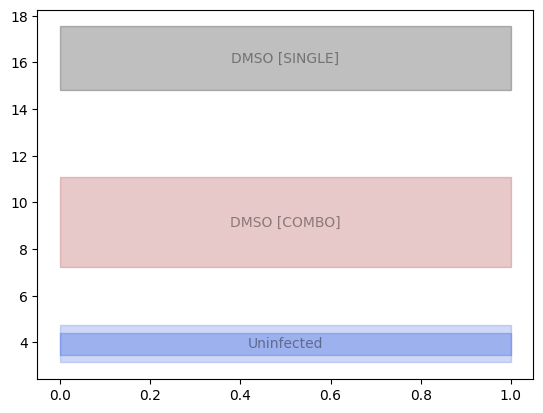

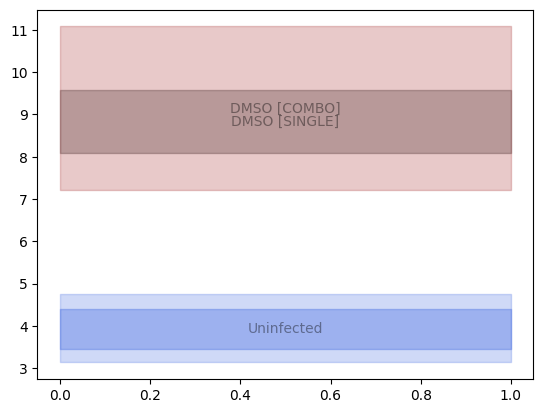

In [17]:
negative_single = avg_pred_single[avg_pred_single['type'] == 'infected'].copy()
negative_combo = avg_pred_combo[avg_pred_combo['type'] == 'infected'].copy()

plot_two_negative(negative_single, negative_combo, n_components=16)

def linear_transform(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

# xmin = negative_combo['distance_median'].iloc[0] - negative_combo['distance_q_25'].iloc[0]
# xmax = negative_combo['distance_median'].iloc[0] + negative_combo['distance_q_75'].iloc[0]

xmin = 0
xmax = negative_single['distance_median'].iloc[0] / negative_combo['distance_median'].iloc[0]

# xmin = 0
# xmax = 1

for col in negative_single.columns:
    if 'distance_' in col:
        negative_single[col] = negative_single[col].apply(lambda x: linear_transform(x, xmin, xmax))

plot_two_negative(negative_single, negative_combo, n_components=16)

In [18]:
drugs_single = avg_pred_single[avg_pred_single['type'] != 'infected'].copy()
drugs_combo = avg_pred_combo[avg_pred_combo['type'] != 'infected'].copy()

for col in drugs_single.columns:
    if 'distance_' in col:
        drugs_single[col] = drugs_single[col].apply(lambda x: linear_transform(x, xmin, xmax))

In [19]:
# Map batch_id's to compound names
with open("data/id_to_name.txt", 'r') as file:
    table = file.readlines()
id_to_name = {}
for i, line in enumerate(table):
    id_, name = line.rstrip().split('\t')
    id_to_name[id_] = name

def catch_missing_name(batch_id):
    if batch_id not in id_to_name:
        raise KeyError(f"Could not find batch_id {batch_id} in the mapping")
    return id_to_name[batch_id]
        

drugs_combo['name_1'] = drugs_combo['batch_id_1'].map(catch_missing_name)
drugs_combo['name_2'] = drugs_combo['batch_id_2'].map(catch_missing_name)

In [20]:
def plot_compounds_separately(drugs_single, drugs_combo, negative_single, negative_combo, n_components=None, metric='distance'):
    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    conf_intervals = [0.5, 0.75]
    healthy_left = dict()
    healthy_right = dict()
    for conf in conf_intervals:
        if metric == 'distance':
            left_sq, right_sq = stats.chi2.interval(confidence=conf, df=n_components)
            healthy_left[conf], healthy_right[conf] = np.sqrt(left_sq), np.sqrt(right_sq)        
        elif metric == 'proba':
            healthy_left[conf],  healthy_right[conf] = conf, 1
        
    neg_left_single = negative_single[y_metric].iloc[0] - negative_single[y_metric_q_25].iloc[0]
    neg_right_single = negative_single[y_metric].iloc[0] + negative_single[y_metric_q_75].iloc[0]
    neg_left_combo = negative_combo[y_metric].iloc[0] - negative_combo[y_metric_q_25].iloc[0]
    neg_right_combo = negative_combo[y_metric].iloc[0] + negative_combo[y_metric_q_75].iloc[0]

    if metric == 'distance':
        ymin, ymax = min(healthy_left.values()), max(neg_right_single, neg_right_combo) + 1
    elif metric == 'proba':
        ymin, ymax = 0, 1

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    batch_ids = drugs_combo['batch_id_1'].unique()
    cols = 4
    rows = len(batch_ids) // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    fig.tight_layout()

    # Iterate over compounds
    for r in range(rows):
        for c in range(cols):
            i = r * 4 + c
            if i == len(batch_ids):
                break
            batch_id = batch_ids[i]

            ## SINGLE ##
            # Plot single drug from `drugs_single`
            compound = drugs_single[(drugs_single['batch_id'] == batch_id)]
            sort_arg = np.argsort(compound['conc'])
            conc = compound['conc'].to_numpy()[sort_arg]
            y_values = compound[y_metric].to_numpy()[sort_arg]
            y_perc_25 = compound[y_metric_q_25].to_numpy()[sort_arg]
            y_perc_75 = compound[y_metric_q_75].to_numpy()[sort_arg]
            axs[r, c].errorbar(
                conc, y_values, yerr=[y_perc_25, y_perc_75], 
                capsize=2, elinewidth=1.5, label='single', c='k'
            )
            x_single = conc
            ####

            ## COMBO ##
            combo_ids = drugs_combo[drugs_combo['batch_id_1'] == batch_id]['combo_id'].unique()
            if len(combo_ids) > 1:
                # Plot combinations from `drugs_combo`
                for j, combo_id in enumerate(combo_ids):
                    compound = drugs_combo[(drugs_combo['batch_id_1'] == batch_id) & (drugs_combo['combo_id'] == combo_id)]
                    conc_2 = np.sort(compound['conc_2'].unique())
                    for k, p_conc in enumerate(conc_2):
                        selected = compound[compound['conc_2'] == p_conc]
                        sort_arg = np.argsort(selected['conc_1'])
                        conc_1 = selected['conc_1'].to_numpy()[sort_arg]
                        y_values = selected[y_metric].to_numpy()[sort_arg]
                        y_perc_25 = selected[y_metric_q_25].to_numpy()[sort_arg]
                        y_perc_75 = selected[y_metric_q_75].to_numpy()[sort_arg]
                        linestyle = '-' if k == 0 else '--'
                        axs[r, c].errorbar(
                            conc_1, y_values, yerr=[y_perc_25, y_perc_75], 
                            capsize=2, elinewidth=1.5, ls=linestyle, c=colors[j % len(colors)],
                            label=(selected['name_2'].iloc[0] + f' at {p_conc}')
                        )
            else:
                # Plot single drug from `drugs_combo`
                compound = drugs_combo[(drugs_combo['batch_id_1'] == batch_id)]
                sort_arg = np.argsort(compound['conc_1'])
                conc_1 = compound['conc_1'].to_numpy()[sort_arg]
                y_values = compound[y_metric].to_numpy()[sort_arg]
                y_perc_25 = compound[y_metric_q_25].to_numpy()[sort_arg]
                y_perc_75 = compound[y_metric_q_75].to_numpy()[sort_arg]
                axs[r, c].errorbar(
                    conc_1, y_values, yerr=[y_perc_25, y_perc_75], 
                    capsize=2, elinewidth=1.5, label='single'
                )

            x_combo = drugs_combo[drugs_combo['batch_id_1'] == batch_id]['conc_1'].unique()
            if len(x_combo) <= 1:
                x_combo = [drugs_combo['conc_1'].min(), drugs_combo['conc_1'].max()]
            drug_name = drugs_combo[drugs_combo['batch_id_1'] == batch_id]['name_1'].iloc[0]
            ####

            x_ticks = np.sort(list(set(x_combo).union(set(x_single))))
            plot_name = f"{drug_name} [{batch_id}]"
            
            # Uninfected cells - confidence intervals
            for i, conf in enumerate(conf_intervals):
                label = "Uninfected" if i == 0 else None
                axs[r, c].fill_between(
                    x_ticks, healthy_left[conf], healthy_right[conf], 
                    color='royalblue', alpha=0.5*(1-conf)**0.5, 
                    zorder=1, label=label
                )
            axs[r, c].text(
                (x_ticks[0]+x_ticks[-1])/2, (healthy_left[conf]+healthy_right[conf])/2, 
                'Uninfected', ha='center', va='center', alpha=0.4
            )
            # Negative state (DMSO) from SINGLE
            axs[r, c].fill_between(
                x_ticks, neg_left_single, neg_right_single, 
                color='brown', alpha=0.25, zorder=1,
            )
            axs[r, c].text(
                (x_ticks[0]+x_ticks[-1])/2, (neg_left_single+neg_right_single)/2,
                'DMSO [SINGLE]', ha='center', va='center', alpha=0.4,
            )

            # Negative state (DMSO) from COMBO
            axs[r, c].fill_between(
                x_ticks, neg_left_combo, neg_right_combo, 
                color='k', alpha=0.25, zorder=1,
            )
            axs[r, c].text(
                (x_ticks[0]+x_ticks[-1])/2, (neg_left_combo+neg_right_combo)/2,
                'DMSO [COMBO]', ha='center', va='center', alpha=0.4,
            )

            axs[r, c].set_title(plot_name, fontsize=10)
            # axs[r, c].set_xticks(x_ticks)
            # axs[r, c].set_xscale('log')
            axs[r, c].set_ylim(ymin, ymax)
            if c == 0:
                axs[r, c].set_ylabel(f'{metric}')
            if r == rows - 1:
                axs[r, c].set_xlabel('concentration')

    last_col = len(batch_ids) - (rows-1)*4
    for c in range(last_col, cols):
        axs[rows-1, c].set_axis_off()
    os.makedirs("output", exist_ok=True)
    fig.savefig(f"output/Covid-single-vs-combo-{metric}.png", dpi=300, bbox_inches="tight")


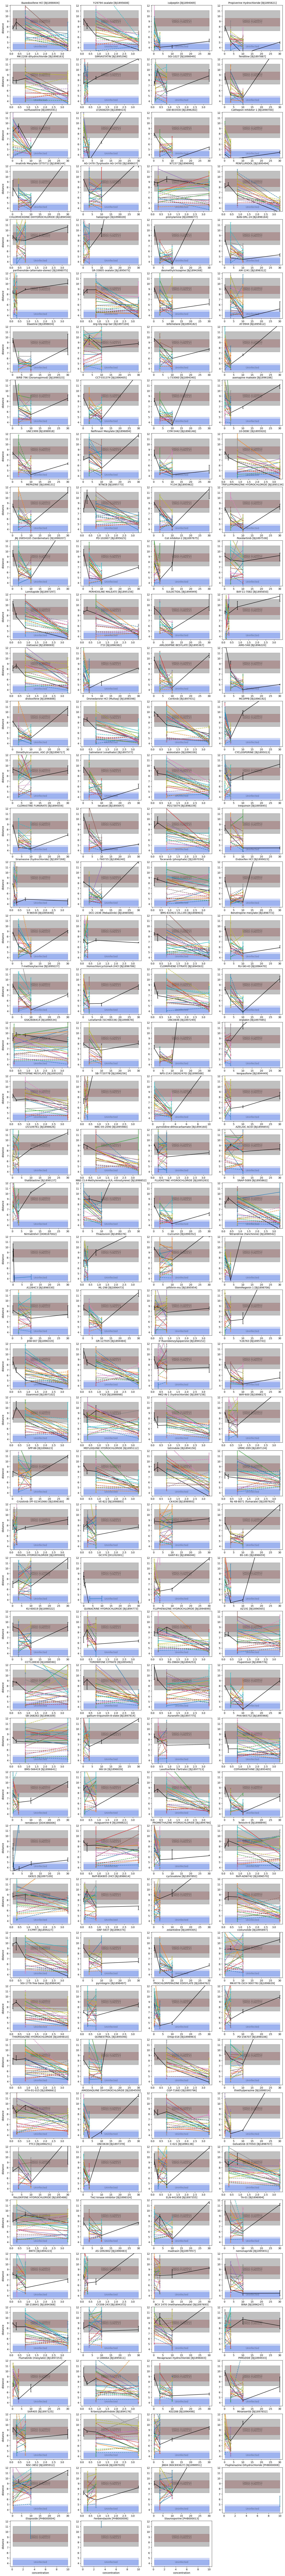

In [21]:
plot_compounds_separately(drugs_single, drugs_combo, negative_single, negative_combo, n_components=N_COMPONENTS)